In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from cvxpy.settings import OPTIMAL

# DATA

In [2]:
m = 0.1
theta = 15 * np.pi/180
T_max = 2
p_init = np.array([0, 0])
p_des = np.array([10, 2])
h = 0.1

In [3]:
def F(theta, T_left, T_right):
    s = np.sin(theta)
    c = np.cos(theta)
    
    ms_c = np.matrix([[-1*s], [c]])
    s_c = np.matrix([[s], [c]])
    
    Tl = T_left@ms_c.T
    Tr = T_right@s_c.T
    grav_force = np.repeat(m*np.matrix([[0], [-9.8]]).T, Tl.shape[0], axis=0)
    
    f = Tl + Tr + grav_force
    
    return f
    
def get_v_p(F):
    M = np.ones((F.shape[0], F.shape[0]))
    M = np.tril(M, -1)
    V = (h/m)*M@F
    P = h*M@V
    return V, P

In [4]:
upper_limit = 1000
lower_limit = 1

k = int((lower_limit + upper_limit)/2)

MAX_ITRS = 10
i = 0
while lower_limit <= upper_limit and i <= MAX_ITRS and k > 1:
    k = int((lower_limit + upper_limit)/2)
    print("L:- {}, U:- {}, K:- {}".format(lower_limit, upper_limit, k))
    T_left = cp.Variable((k, 1))
    T_right = cp.Variable((k, 1))
    
    f = F(theta, T_left, T_right)
    V, P = get_v_p(f)
    
    Constraints = [
        P[0, :] == p_init,
        P[-1, :] == p_des,
        V[0, :] == np.zeros(2),
        V[-1, :] == np.zeros(2),
        T_left >= 0,
        T_left <= T_max,
        T_right >= 0,
        T_right <= T_max
    ]
    
    Objective = cp.Minimize(0)
    
    problem = cp.Problem(objective=Objective, constraints=Constraints)
    
    problem.solve()
    if upper_limit == lower_limit:
        break
        
    if problem.status == OPTIMAL:
        upper_limit = k
    else:
        lower_limit = k+1
    i += 1
    

L:- 1, U:- 1000, K:- 500
L:- 1, U:- 500, K:- 250
L:- 1, U:- 250, K:- 125
L:- 1, U:- 125, K:- 63
L:- 1, U:- 63, K:- 32
L:- 33, U:- 63, K:- 48
L:- 33, U:- 48, K:- 40
L:- 33, U:- 40, K:- 36
L:- 33, U:- 36, K:- 34
L:- 33, U:- 34, K:- 33
L:- 34, U:- 34, K:- 34


# k* = 34, Minimum time is 3.4s

Text(0, 0.5, 'N')

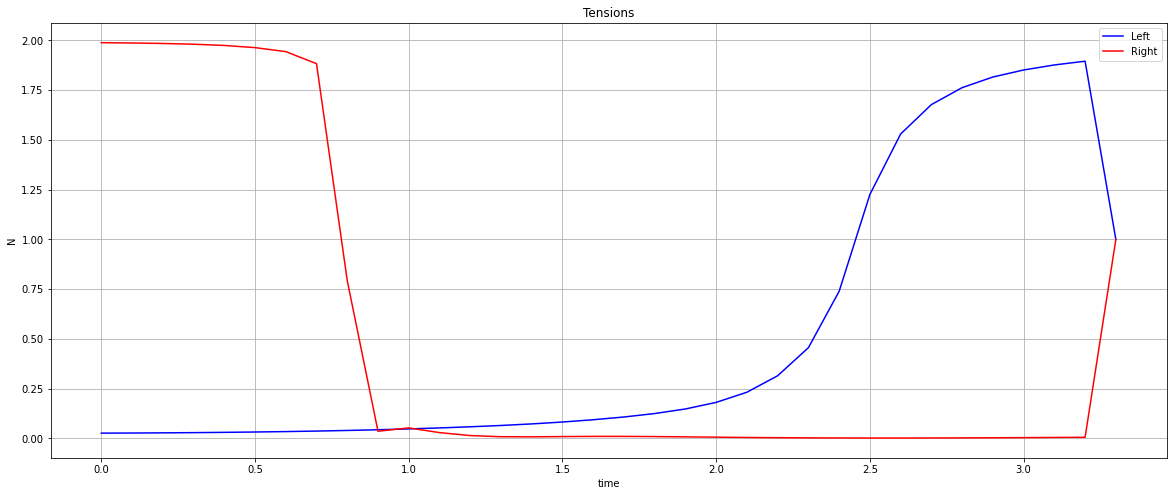

In [5]:
T = h*np.arange(k)

plt.figure(figsize=(20, 8))
plt.title("Tensions")
plt.plot(T, T_left.value, "b", label="Left")
plt.plot(T, T_right.value, "r", label="Right")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("N")

Text(0.5, 0, 'x')

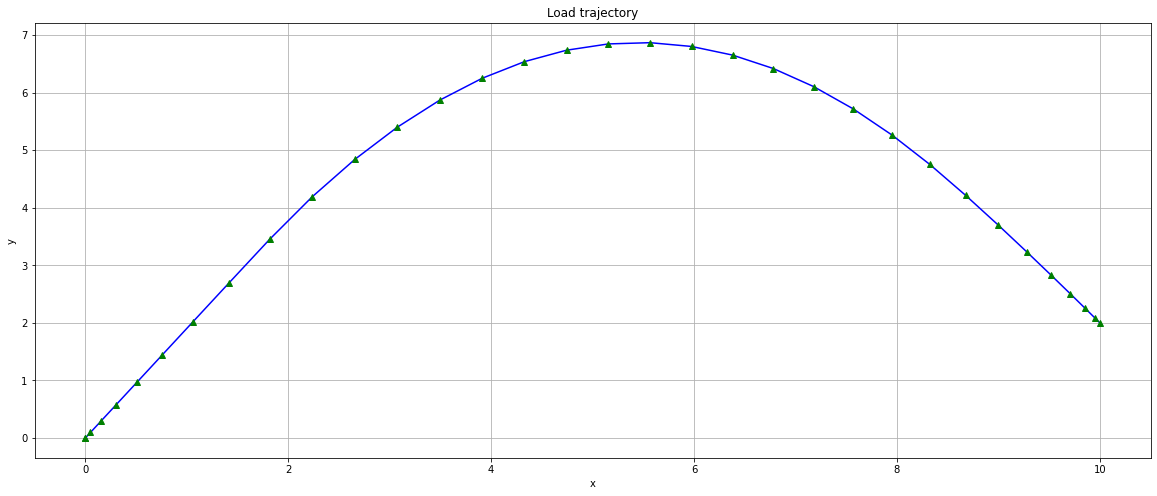

In [6]:
plt.figure(figsize=(20, 8))
plt.title("Load trajectory")
plt.plot(P.value[:, 0], P.value[:, 1], "b")
plt.plot(P.value[:, 0], P.value[:, 1], "g^")
plt.grid()
plt.ylabel("y")
plt.xlabel("x")

# The shortest path is not line segment